In [46]:
spark

#### Part1

In [4]:

import pandas as pd
df = pd.read_excel('/home/exouser/bigdata/Sunflower_Seeds_Dataset.xlsx')

In [5]:
df.head()

,Total Area,Boundary Length,Max Length,Min Length,Convex Boundary Area,Circular Diameter,Seed Eccentricity,Convexity Factor,Coverage Ratio,Shape Roundness,Ovality Index,Shape Ratio,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,High_Quality
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,High_Quality
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,High_Quality
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,High_Quality
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,High_Quality


In [6]:
df_seed= spark.createDataFrame(df)

In [7]:
df_seed.show(truncate = False)

+----------+---------------+----------+----------+--------------------+-----------------+-----------------+----------------+--------------+---------------+-------------+-----------+------------+
|Total Area|Boundary Length|Max Length|Min Length|Convex Boundary Area|Circular Diameter|Seed Eccentricity|Convexity Factor|Coverage Ratio|Shape Roundness|Ovality Index|Shape Ratio|Class       |
+----------+---------------+----------+----------+--------------------+-----------------+-----------------+----------------+--------------+---------------+-------------+-----------+------------+
|56276     |888.242        |326.1485  |220.2388  |56831               |267.6805         |0.7376           |0.9902          |0.7453        |0.8963         |1.4809       |0.8207     |High_Quality|
|76631     |1068.146       |417.1932  |234.2289  |77280               |312.3614         |0.8275           |0.9916          |0.7151        |0.844          |1.7811       |0.7487     |High_Quality|
|71623     |1082.987     

In [8]:
df_seed = df_seed.withColumnsRenamed({'Total Area' : 'Seed_Area','Boundary Length' : 'Seed_Perimeter',\
                                      'Max Length' : 'Long_Axis_Length','Min Length' : 'Short_Axis_Length',\
                                      'Seed Eccentricity' : 'Seed_Eccentricity','Convex Boundary Area' : 'Convex_Hull_Area',\
                                      'Coverage Ratio' : 'Bounding_Box_Extent','Circular Diameter' : 'Equivalent_Diameter',\
                                      'Shape Ratio' : 'Shape_Compactness','Convexity Factor' : 'Shape_Solidity',\
                                      'Ovality Index' : 'Aspect_Ratio','Shape Roundness' : 'Shape_Roundness'
                                     })

In [9]:
df_seed.show()

+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+------------+
|Seed_Area|Seed_Perimeter|Long_Axis_Length|Short_Axis_Length|Convex_Hull_Area|Equivalent_Diameter|Seed_Eccentricity|Shape_Solidity|Bounding_Box_Extent|Shape_Roundness|Aspect_Ratio|Shape_Compactness|       Class|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+------------+
|    56276|       888.242|        326.1485|         220.2388|           56831|           267.6805|           0.7376|        0.9902|             0.7453|         0.8963|      1.4809|           0.8207|High_Quality|
|    76631|      1068.146|        417.1932|         234.2289|           77280|           312.3614|           0.8275|        0.9916|             0.7151| 

In [10]:
### Dataset Overview
print("number of rows ",df_seed.count(), "number of columns",len(df_seed.columns))

number of rows  2500 number of columns 13


In [11]:
### data types for each column
df_seed.printSchema()

root
 |-- Seed_Area: long (nullable = true)
 |-- Seed_Perimeter: double (nullable = true)
 |-- Long_Axis_Length: double (nullable = true)
 |-- Short_Axis_Length: double (nullable = true)
 |-- Convex_Hull_Area: long (nullable = true)
 |-- Equivalent_Diameter: double (nullable = true)
 |-- Seed_Eccentricity: double (nullable = true)
 |-- Shape_Solidity: double (nullable = true)
 |-- Bounding_Box_Extent: double (nullable = true)
 |-- Shape_Roundness: double (nullable = true)
 |-- Aspect_Ratio: double (nullable = true)
 |-- Shape_Compactness: double (nullable = true)
 |-- Class: string (nullable = true)



In [12]:
### unique values present in the target column (Quality)
df_seed.select('Class').distinct().show()

+------------+
|       Class|
+------------+
|High_Quality|
| Low_Quality|
+------------+



#### Part 2

In [13]:
### Descriptive Statistics
from pyspark.sql.types import *
num_ip = []
str_ip = []
for col in df_seed.columns:
    if str(df_seed.schema[col].dataType) == 'StringType()':
        str_ip.append(col)
    else:
        num_ip.append(col)

In [14]:
num_ip

['Seed_Area',
 'Seed_Perimeter',
 'Long_Axis_Length',
 'Short_Axis_Length',
 'Convex_Hull_Area',
 'Equivalent_Diameter',
 'Seed_Eccentricity',
 'Shape_Solidity',
 'Bounding_Box_Extent',
 'Shape_Roundness',
 'Aspect_Ratio',
 'Shape_Compactness']

In [15]:
str_ip

['Class']

In [16]:
## check missing values before before statistical analysis
from pyspark.sql.functions import isnan, when, count, col, format_number
nulls = df_seed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_seed.columns])
nulls.show()

+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+-----+
|Seed_Area|Seed_Perimeter|Long_Axis_Length|Short_Axis_Length|Convex_Hull_Area|Equivalent_Diameter|Seed_Eccentricity|Shape_Solidity|Bounding_Box_Extent|Shape_Roundness|Aspect_Ratio|Shape_Compactness|Class|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+-----+
|        0|             0|               0|                0|               0|                  0|                0|             0|                  0|              0|           0|                0|    0|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+

No null values, safe to proceed

In [17]:
df_seed[num_ip].describe().toPandas()

24/10/27 05:19:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Seed_Area,Seed_Perimeter,Long_Axis_Length,Short_Axis_Length,Convex_Hull_Area,Equivalent_Diameter,Seed_Eccentricity,Shape_Solidity,Bounding_Box_Extent,Shape_Roundness,Aspect_Ratio,Shape_Compactness
0,count,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
1,mean,80658.2208,1130.2790148000008,456.60184016000005,225.79492115999994,81508.0844,319.33423000000016,0.8608794,0.9894916000000002,0.6932045200000002,0.7915327600000002,2.041702319999999,0.7041205199999999
2,stddev,13664.510228382134,109.25641774887876,56.235703949818195,23.297244577915166,13764.092788258518,26.891919729810493,0.04516739852145229,0.0034935923510057967,0.06091364803208084,0.05592394662311274,0.31599688383092384,0.0530668849343942
3,min,47939,868.485,320.8446,152.1718,48366,247.0584,0.4921,0.9186,0.468,0.5546,1.1487,0.5608
4,max,136574,1559.45,661.9113,305.818,138384,417.0029,0.9481,0.9944,0.8296,0.9396,3.1444,0.9049


In [18]:
#### outliers
from pyspark.sql.functions import *
d = {}
for col in num_ip:
    d[col] = df_seed.approxQuantile(col,[0.25,0.50,0.75],0)

d

{'Seed_Area': [70747.0, 79074.0, 89747.0],
 'Seed_Perimeter': [1048.691, 1123.571, 1203.295],
 'Long_Axis_Length': [414.9502, 449.4759, 492.7192],
 'Short_Axis_Length': [211.2349, 224.6764, 240.6674],
 'Convex_Hull_Area': [71506.0, 79870.0, 90793.0],
 'Equivalent_Diameter': [300.1298, 317.3013, 338.0376],
 'Seed_Eccentricity': [0.8317, 0.8637, 0.897],
 'Shape_Solidity': [0.9883, 0.9903, 0.9915],
 'Bounding_Box_Extent': [0.6586, 0.713, 0.7402],
 'Shape_Roundness': [0.7519, 0.7977, 0.8343],
 'Aspect_Ratio': [1.8009, 1.9842, 2.2618],
 'Shape_Compactness': [0.6634, 0.7077, 0.7435]}

In [19]:
### outliers
from pyspark.sql import functions as F

outliers = {}

for col, quantiles in d.items():
    Q1, Q3 = quantiles[0], quantiles[2]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter outliers in df_seed for the current column
    outliers[col] = df_seed.filter((F.col(col) < lower_bound) | (F.col(col) > upper_bound)).select(col).collect()

In [20]:
### count of outliers for each columns
row_counts = {key: len(values) for key, values in outliers.items()}
print(row_counts)

{'Seed_Area': 18, 'Seed_Perimeter': 16, 'Long_Axis_Length': 21, 'Short_Axis_Length': 30, 'Convex_Hull_Area': 17, 'Equivalent_Diameter': 13, 'Seed_Eccentricity': 18, 'Shape_Solidity': 103, 'Bounding_Box_Extent': 45, 'Shape_Roundness': 5, 'Aspect_Ratio': 11, 'Shape_Compactness': 2}


The above is the count of outliers for each columns, lets resolve the outliers issue with the help of calculating the skewness and treat respectively, without eliminating the natural outliers.

In [21]:
### skweness

for col in num_ip:
    skew = df_seed.agg(skewness(df_seed[col])).collect()
    skew = skew[0][0]
    print(col,"skew : ", skew)
    if skew > 1:
        df_seed = df_seed.withColumn(col, \
        log(when(df_seed[col]< d[col][0],d[col][0])\
        .when(df_seed[col]>d[col][1],d[col][1])\
        .otherwise(df_seed[col]) + 1)).alias(col)
        print(col+" has been treated for positive (right) skewness. (skew =",skew,")")
    elif skew < -1:
        df_seed = df_seed.withColumn(col, \
        exp(when(df_seed[col]< d[col][0],d[col][0])\
        .when(df_seed[col]>d[col][1],d[col][1])\
        .otherwise(df_seed[col]) + 1)).alias(col)
        print(col+" has been treated for negative (left) skewness. (skew =",skew,")")
            

Seed_Area skew :  0.4957013599285963
Seed_Perimeter skew :  0.41429008956737834
Long_Axis_Length skew :  0.5026777222523139
Short_Axis_Length skew :  0.10424069175243936
Convex_Hull_Area skew :  0.493719487001989
Equivalent_Diameter skew :  0.2717044442335102
Seed_Eccentricity skew :  -0.748174091015908
Shape_Solidity skew :  -5.687593916963491
Shape_Solidity has been treated for negative (left) skewness. (skew = -5.687593916963491 )
Bounding_Box_Extent skew :  -1.0259522277984028
Bounding_Box_Extent has been treated for negative (left) skewness. (skew = -1.0259522277984028 )
Shape_Roundness skew :  -0.3724634670454338
Aspect_Ratio skew :  0.547902099509973
Shape_Compactness skew :  -0.06233914581156275


Finally, we fixed the outliers issue with the help of skewness, i.e Shape_Solidity and Bounding_Box_Extent, these 2 are found to have genuine outliers. Where are remaining might have natural outliers. Lets calculate the outliers again below.

In [22]:
d = {}
for col in num_ip:
    d[col] = df_seed.approxQuantile(col,[0.25,0.50,0.75],0)
for col, quantiles in d.items():
    Q1, Q3 = quantiles[0], quantiles[2]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter outliers in df_seed for the current column
    outliers[col] = df_seed.filter((F.col(col) < lower_bound) | (F.col(col) > upper_bound)).select(col).collect()
row_counts = {key: len(values) for key, values in outliers.items()}
print(row_counts)

24/10/27 05:19:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


{'Seed_Area': 18, 'Seed_Perimeter': 16, 'Long_Axis_Length': 21, 'Short_Axis_Length': 30, 'Convex_Hull_Area': 17, 'Equivalent_Diameter': 13, 'Seed_Eccentricity': 18, 'Shape_Solidity': 0, 'Bounding_Box_Extent': 0, 'Shape_Roundness': 5, 'Aspect_Ratio': 11, 'Shape_Compactness': 2}


Therefore, No outliers now, data is clean and good to proceed

#### Part3

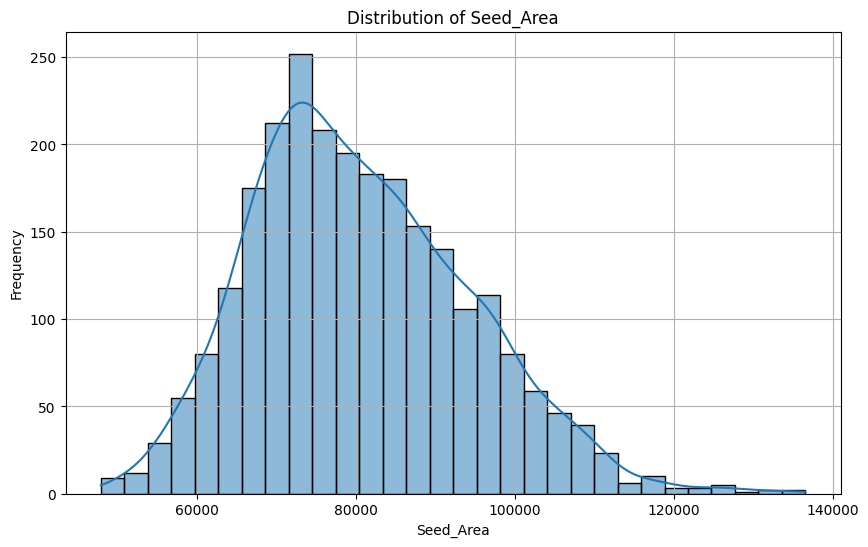

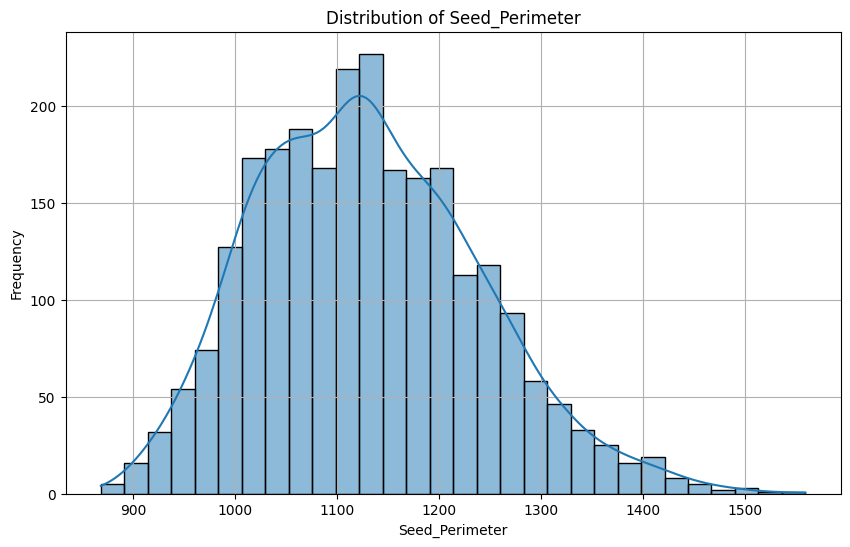

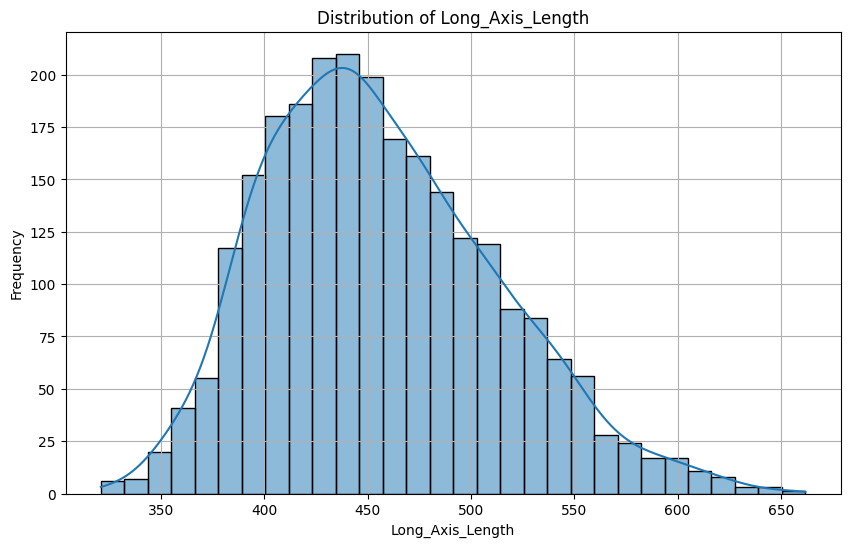

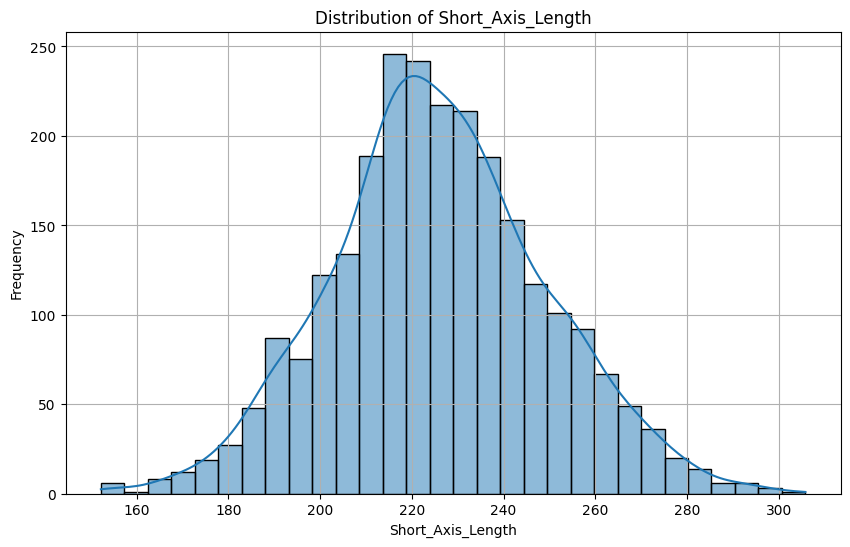

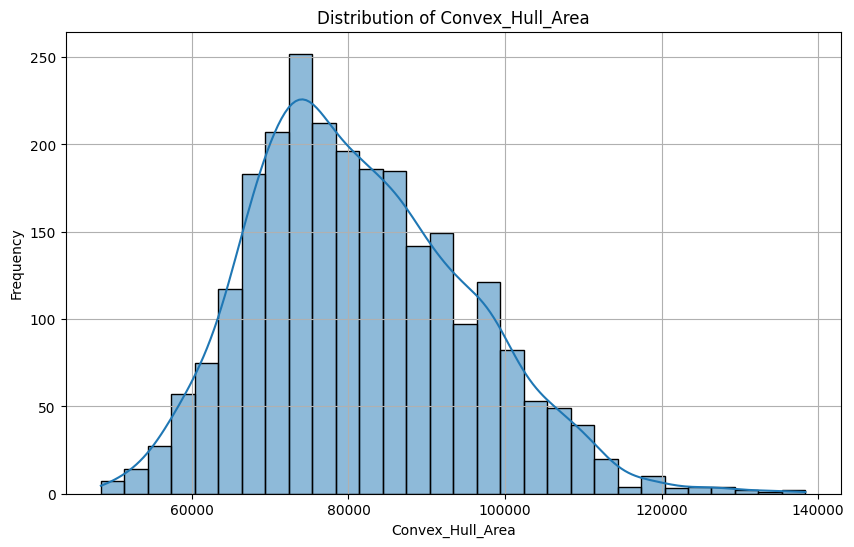

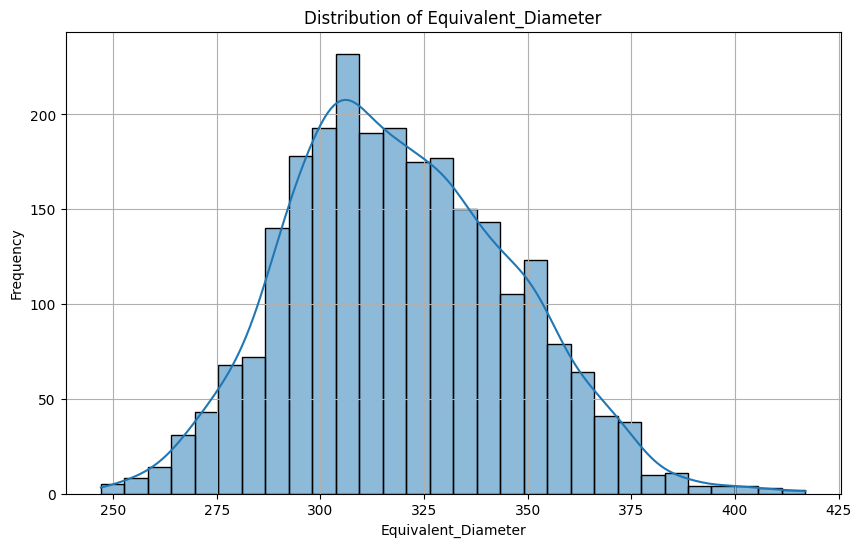

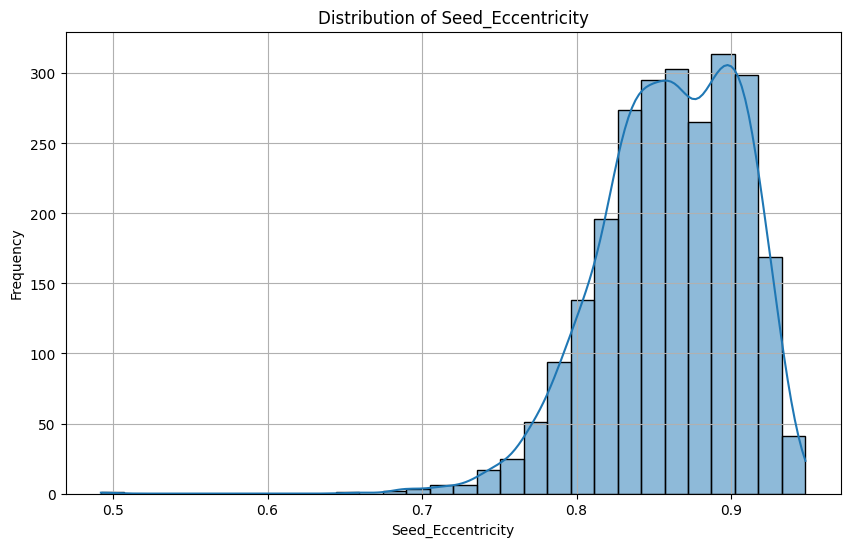

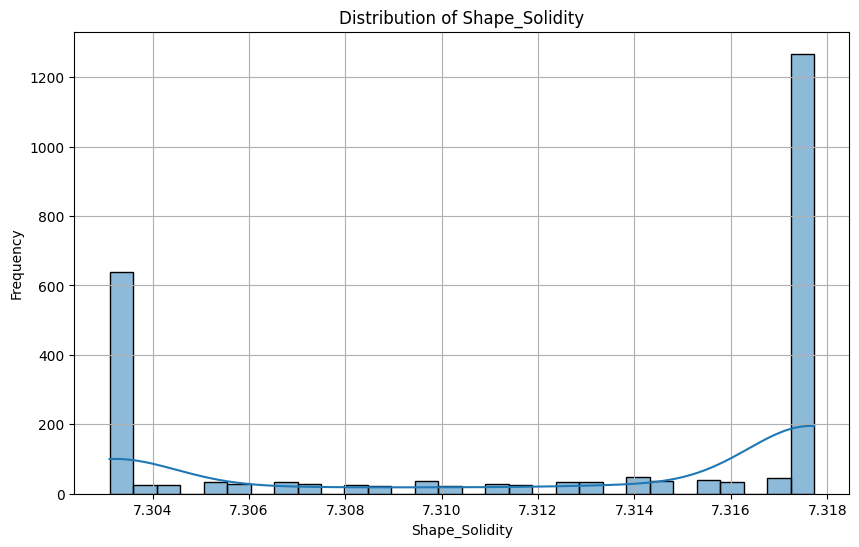

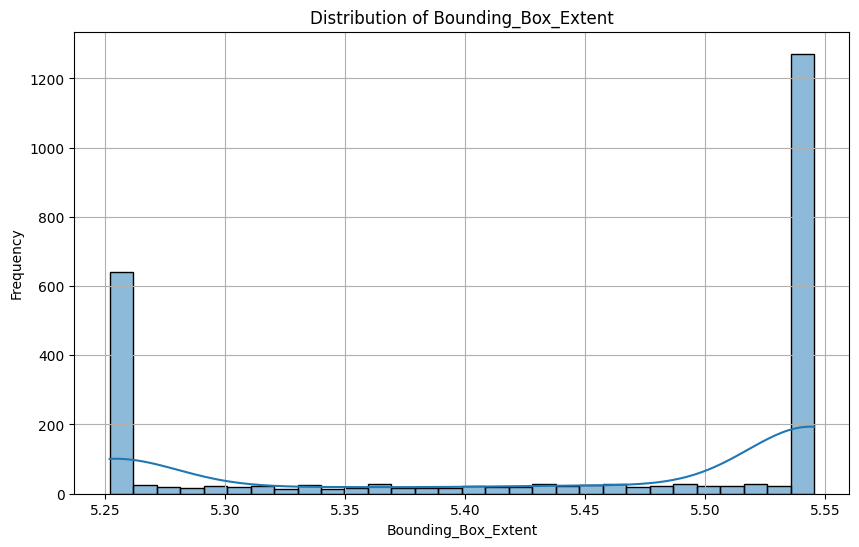

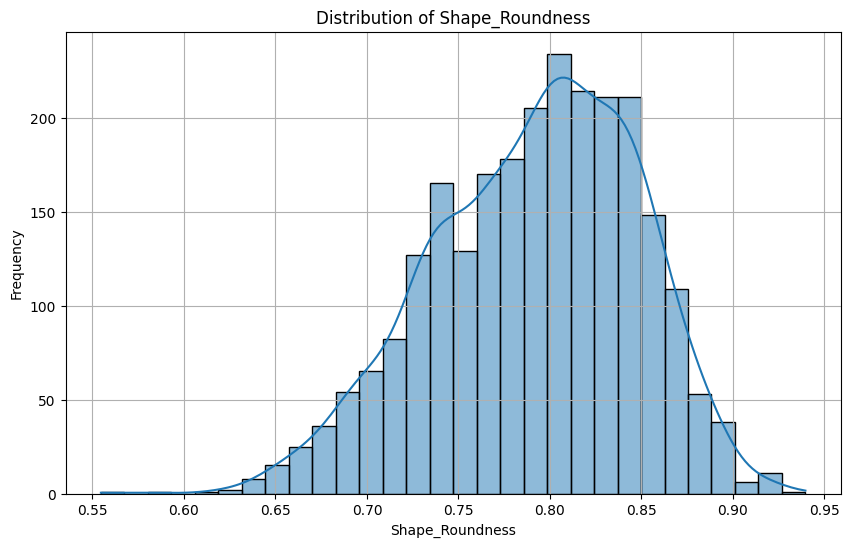

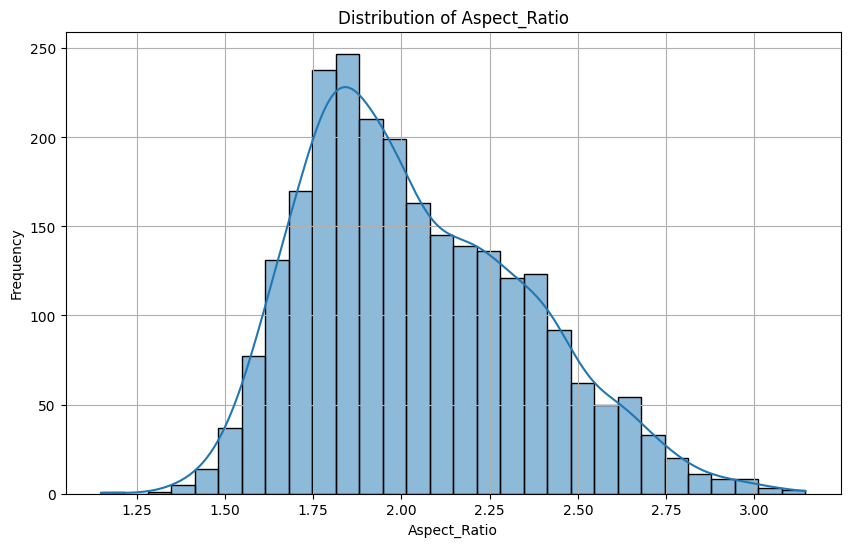

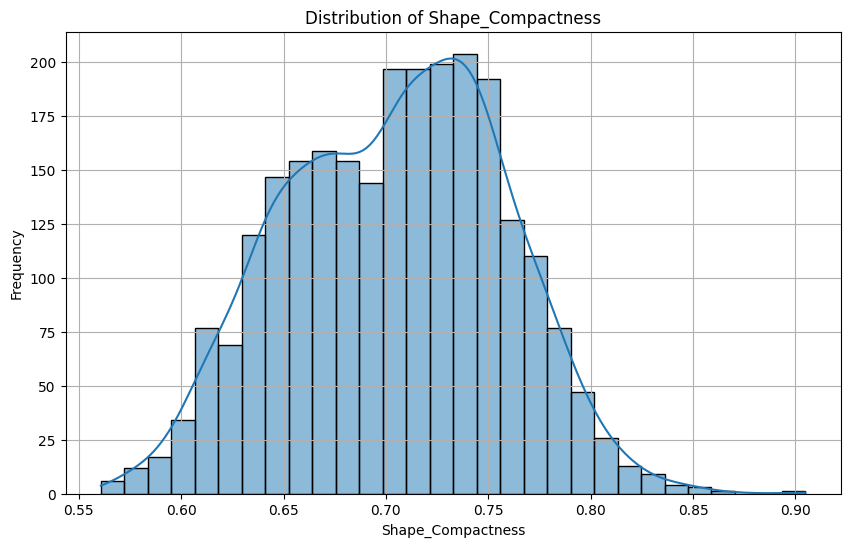

In [23]:
## Analysis for normalisation or standardisation 
import seaborn as sns
import matplotlib.pyplot as plt

for col in num_ip:
    data_column = df_seed.select(col)

    # Convert the Spark DataFrame to Pandas DataFrame
    pandas_df = data_column.toPandas()

    # Plot the distribution using seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(pandas_df[col], bins=30, kde=True)
    plt.title('Distribution of ' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid()

As there are few natural outliers, whthout disturbing the data, lets perfer Normalisationinsted of Standardisation

In [24]:
#Feature Vector
from pyspark.ml.feature import VectorAssembler,StringIndexer
assembler = VectorAssembler(inputCols=num_ip, outputCol= 'features')
output = assembler.transform(df_seed)

In [25]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(inputCol= 'features' , outputCol = 'norm_features')
standard_model = scaler.fit(output)
df_seed_std = standard_model.transform(output)

In [26]:
df_seed_std.select('norm_features').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|norm_features                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.09405990861397867,0.028593344091234645,0.015550917166642182,0.4430112817629073,0.09403674820591437,0.12134608651648032,0.5383771929824562,0.9499524857507544,1.0,0.8875324675324675,0.1664578844515709,0.7553036907875617]              |
|[0.32370959553223894,0.28895964339727764,0.2824

In [27]:
##string_column to numerical conversion
if len(str_ip)!=0:
    for col in str_ip:
        indexer = StringIndexer(inputCol= col , outputCol=col+"_num")
        output  = indexer.fit(df_seed_std).transform(df_seed_std)

In [28]:
output.show(5)

+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+------------------+-------------------+---------------+------------+-----------------+------------+--------------------+--------------------+---------+
|Seed_Area|Seed_Perimeter|Long_Axis_Length|Short_Axis_Length|Convex_Hull_Area|Equivalent_Diameter|Seed_Eccentricity|    Shape_Solidity|Bounding_Box_Extent|Shape_Roundness|Aspect_Ratio|Shape_Compactness|       Class|            features|       norm_features|Class_num|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+------------------+-------------------+---------------+------------+-----------------+------------+--------------------+--------------------+---------+
|    56276|       888.242|        326.1485|         220.2388|           56831|           267.6805|           0.7376| 7.316997015382458|  5.545573267282524|         0.8963|      1.4809|           0

In [29]:
### correlation 
corr = {}
for col in num_ip:
    corr[col] = output.stat.corr(col,'Class_num')
    

In [30]:
corr

{'Seed_Area': 0.17028023752047416,
 'Seed_Perimeter': 0.38834537994362867,
 'Long_Axis_Length': 0.5614577859185197,
 'Short_Axis_Length': -0.40136249277404923,
 'Convex_Hull_Area': 0.1680294517960905,
 'Equivalent_Diameter': 0.16030261525034054,
 'Seed_Eccentricity': 0.6993187372600782,
 'Shape_Solidity': 0.16181918039835125,
 'Bounding_Box_Extent': -0.20304771800038438,
 'Shape_Roundness': -0.6695138749204715,
 'Aspect_Ratio': 0.721796419479348,
 'Shape_Compactness': -0.7266759415864825}

Among all the columns Aspect_Ratio has a strong positive correlation, and Shape_Compactness strong negative correlation

#### Part4

In [41]:
### equal distribution of Class
output = output.withColumnRenamed('norn_features','features')

In [45]:
### a the label is categorical data of 2, the distribution is obviously equally distributed

In [42]:
train,test = output.randomSplit([0.8,0.2],seed= 42)

In [43]:
train.agg(F.mean('Class_num')).collect()

[Row(avg(Class_num)=0.4769459593455627)]

In [44]:
test.agg(F.mean('Class_num')).collect()

[Row(avg(Class_num)=0.4927536231884058)]

In [64]:
###model training
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
classifier = LogisticRegression(featuresCol='features' , labelCol='Class_num')

In [65]:
fitmodel = classifier.fit(train)

In [68]:

# Evaluation method for binary classification problem

from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictionAndLabels = fitmodel.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class_num")
auc = evaluator.evaluate(predictionAndLabels)
print("AUC:",auc)

# Calculate accuracy, precision, recall, and F1 score
# First, create True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
tp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 1)).count()
fp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 0)).count()
tn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 0)).count()
fn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 1)).count()

# Accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
print(f"Accuracy: {accuracy}")

# Precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall: {recall}")

# F1 Score
f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
print(f"F1 Score: {f1_score}")

AUC: 0.9298062081975649
Accuracy: 0.8674948240165632
Precision: 0.8954545454545455
Recall: 0.8277310924369747
F1 Score: 0.8602620087336244


In [69]:
regressor = DecisionTreeClassifier(featuresCol='features', labelCol='Class_num')
fitmodel = regressor.fit(train)
predictionAndLabels = fitmodel.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class_num")
auc = evaluator.evaluate(predictionAndLabels)
print("AUC:",auc)
# Calculate accuracy, precision, recall, and F1 score
# First, create True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
tp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 1)).count()
fp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 0)).count()
tn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 0)).count()
fn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 1)).count()

# Accuracy
accuracy = (tp + tn) / (tp + fp + tn + fn)
print(f"Accuracy: {accuracy}")

# Precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall: {recall}")

# F1 Score
f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
print(f"F1 Score: {f1_score}")

AUC: 0.7798405076316239
Accuracy: 0.8633540372670807
Precision: 0.9215686274509803
Recall: 0.7899159663865546
F1 Score: 0.8506787330316742


The logistic regression model outperformed the decision tree across several key metrics. It achieved a higher AUC score (0.9298 vs. 0.7798), indicating stronger discrimination between classes. It also had a slightly higher accuracy (0.8675 vs. 0.8634), recall (0.8277 vs. 0.7899), and F1 score (0.8603 vs. 0.8507), making it the better option overall, especially for cases where a balanced approach between recall and precision is required. While the decision tree showed a marginally higher precision (0.9216 vs. 0.8955), which could be beneficial in minimizing false positives, logistic regression's superior recall and overall predictive balance make it more effective in this context.

#### Part 5

Feature Patterns:

Logistic Regression: As a linear model, it tends to perform exceedingly well if the relationships among features are roughly linear, which has been manifested in its performance. It's naturally favored by linear patterns in most datasets.

Decision Tree: A non-linear model, it can take in the complex pattern but is highly dependent on deeper trees or more nodes for good performance. The better performance of logistic regression implies that the present set of features could be more inclined towards linearity.

Stability of Model Performance Across Metrics:
Logistic Regression: Since performance across AUC, accuracy, and F1 score is fairly stable, predictions are stable.
Decision Trees: Most likely to vary between metrics, which in the case of shallow depth-this model can be quite sensitive to overfitting if not tuned right.


Key Insights and Recommendations for Improvement
Feature Engineering:
Polynomial Features: This might give logistic regression the power to capture higher-order relationships that may increase its performance.
Feature Scaling: Although logistic regression can handle unscaled data with minimal problems, scaling usually enhances its performance(which is done here already). Decision trees are not affected by unscaled data; hence, this might not make that much difference in this case.
Feature Pruning for Decision Tree: Shrinking the redundant or weakly predictive features improves decision tree performance by minimizing overfitting, enhancing generalization.

Hyperparameter Tuning:
Logistic Regression: This involves regularization tuning-for example, L2 regularization-which enhances stability in cases where collinearity or noise could be an issue.
Decision Tree: The best parameters are those that maximize the maximum depth, the minimum samples per leaf, and a very critical choice of the splitting criterion in order to avoid overfitting. It also enhances AUC and recall. Pruning will help discard overly complicated branches.

Data Adjustments:
Class Imbalance Handling(Done here): Class imbalance techniques, such as SMOTE or class weight changes, can result in better recall and precision that may benefit the algorithms of logistic regression and decision trees differently.Followed stratified sampling approach.
Outlier Detection and Removal(Done here): This will help in removing the skew arising because of logistic regression learning by filtering through z-score or robust scaling. 

#### Bonus

In [77]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr = LogisticRegression(featuresCol='features', labelCol='Class_num', maxIter=10)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.1, 0.5,1.0]).build()


evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class_num")

# Set up the CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation


In [134]:

cvModel = crossval.fit(train)

In [135]:

bestModel = cvModel.bestModel

print("Best Model Coefficients: ", bestModel.coefficients)
print("Best Model Intercept: ", bestModel.intercept)


predictions = bestModel.transform(test)


accuracy = evaluator.evaluate(predictions)
print(f"Best Model's Accuracy: {accuracy}")

binaryEvaluator = BinaryClassificationEvaluator(labelCol="Class_num", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binaryEvaluator.evaluate(predictions)
print(f"Best Model's AUC: {auc}")


Best Model Coefficients:  [1.3719336517280586e-05,0.0007796688573713026,0.00647113053164263,-0.021590833135969788,1.078245796952121e-05,-0.0039058838290808983,10.122858903210393,83.23058337311075,0.020278108869760867,-9.299807168436372,2.223249795492595,-12.899068934422749]
Best Model Intercept:  -605.282861441421
Best Model's Accuracy: 0.8524609843937575
Best Model's AUC: 0.9191047847710515


In [136]:

# cvModel = crossval.fit(train)
num_folds = 5
folds = train.randomSplit([1.0 / num_folds] * num_folds)
metrics = []

# Iterate through each fold
for i in range(num_folds):
    # Create training and validation sets
    validation_set = folds[i]
    training_set = None

    # Union the other folds to create the training set
    for j in range(num_folds):
        if j != i:
            if training_set is None:
                training_set = folds[j]
            else:
                training_set = training_set.union(folds[j])

    # Define the Logistic Regression model
    lr = LogisticRegression(featuresCol='features', labelCol='Class_num', maxIter=10)

    # Fit the model on the training set
    model = lr.fit(training_set)

    # Make predictions on the validation set
    predictions = model.transform(validation_set)

    # Prepare prediction and labels DataFrame
    predictionAndLabels = predictions.select("prediction", "Class_num")

    # Initialize the BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Class_num")
    auc = evaluator.evaluate(predictionAndLabels)
    print(f"AUC for fold {i + 1}: {auc}")

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
    tp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 1)).count()
    fp = predictionAndLabels.filter((F.col("prediction") == 1) & (F.col("Class_num") == 0)).count()
    tn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 0)).count()
    fn = predictionAndLabels.filter((F.col("prediction") == 0) & (F.col("Class_num") == 1)).count()

    # Accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0
    print(f"Accuracy for fold {i + 1}: {accuracy}")

    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    print(f"Precision for fold {i + 1}: {precision}")

    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"Recall for fold {i + 1}: {recall}")

    # F1 Score
    f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
    print(f"F1 Score for fold {i + 1}: {f1_score}")

    # Store the metrics for this fold
    metrics.append((auc, accuracy, precision, recall, f1_score))


AUC for fold 1: 0.8730903942171547
Accuracy for fold 1: 0.8756218905472637
Precision for fold 1: 0.8971428571428571
Recall for fold 1: 0.8306878306878307
F1 Score for fold 1: 0.8626373626373626
AUC for fold 2: 0.8725655746932343
Accuracy for fold 2: 0.8726790450928382
Precision for fold 2: 0.9069767441860465
Recall for fold 2: 0.8297872340425532
F1 Score for fold 2: 0.8666666666666666
AUC for fold 3: 0.8695194258074583
Accuracy for fold 3: 0.8683544303797468
Precision for fold 3: 0.8315217391304348
Recall for fold 3: 0.8793103448275862
F1 Score for fold 3: 0.8547486033519555
AUC for fold 4: 0.8888321416411304
Accuracy for fold 4: 0.8882978723404256
Precision for fold 4: 0.90625
Recall for fold 4: 0.8787878787878788
F1 Score for fold 4: 0.8923076923076922
AUC for fold 5: 0.8733226128424088
Accuracy for fold 5: 0.8758029978586723
Precision for fold 5: 0.8780487804878049
Recall for fold 5: 0.8450704225352113
F1 Score for fold 5: 0.8612440191387559


Observation - Overall, the model is relatively stable and reliable across folds while yielding an AUC of about 0.87 to 0.89 and balanced precision, recall, and F1 score. The model does somewhat better in minimizing false positives than in maximizing the identification of true positives, but it maintains strong performance in both parameters. This balanced performance would further suggest that the model is effective and suitable for tasks where both accuracy and a good balance between sensitivity (recall) and specificity (precision) are desired.